Dataset: https://www.kaggle.com/competitions/dog-breed-identification/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator

In [ ]:
# TensorFlow ve GPU Ayarları (Colab T4 GPU için)
try:
    # TensorFlow'un GPU kullanmasını etkinleştir
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set to True")
    else:
        print("No GPU devices found")
except:
    # GPU bulunamazsa veya hata alınırsa
    print("Failed to set GPU memory growth")

# T4 GPU kullanılabilirliğini kontrol et
try:
    if tf.test.gpu_device_name() == '/device:GPU:0':
        print('GPU: Tesla T4')
    else:
        raise SystemError('GPU Device not found')
except:
    print('No GPU found. Running on CPU.')




GPU memory growth set to True
GPU: Tesla T4


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/dog-breed-identification.zip"
extract_path = "/content/drive/MyDrive/dog-breed-identification"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

extracted_files = os.listdir(extract_path)
print("Çıkartılan dosyalar:")
print(extracted_files)


In [ ]:
data_dir = '/content/drive/MyDrive/dog-breed-identification/train/'

file_names = os.listdir(data_dir)

train_df = pd.DataFrame(file_names, columns=['id'])
train_df['breed'] = train_df['id'].apply(lambda x: x.split('.')[0])

pixels = []
for file_name in tqdm(file_names, desc='Processing Images'):
    img_path = os.path.join(data_dir, file_name)
    img = Image.open(img_path)
    img = img.resize((64, 64))
    img_array = np.array(img)
    pixels.append(img_array.flatten())

Processing Images: 100%|██████████| 7260/7260 [03:02<00:00, 39.79it/s] 


In [ ]:
pixel_df = pd.DataFrame(pixels)

In [ ]:
label_onehot = pd.get_dummies(train_df['breed'])

final_df = pd.concat([pixel_df, label_onehot], axis=1)

X = final_df.iloc[:, :-120]
y = final_df.iloc[:, -120:]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5082, 7140)
X_val shape: (1089, 7140)
X_test shape: (1089, 7140)
y_train shape: (5082, 120)
y_val shape: (1089, 120)
y_test shape: (1089, 120)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               914048    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 120)               7800      
                                                                 
Total params: 930104 (3.55 MB)
Trainable params: 930104 (3.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
159/159 [==============================] - 8s 7ms/step - loss: 0.0957 - accuracy: 0.0000e+00 - val_loss: 0.0923 - val_accuracy: 0.0000e+00
Ep

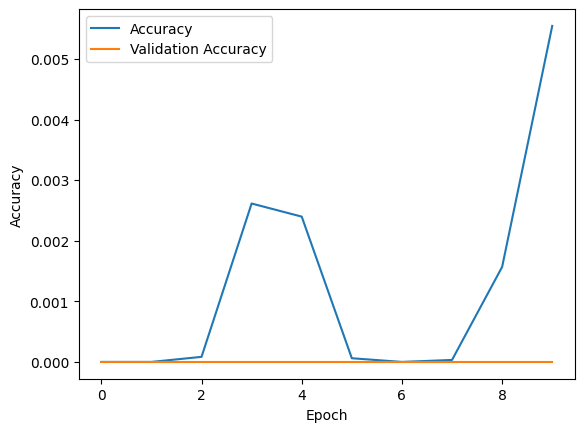

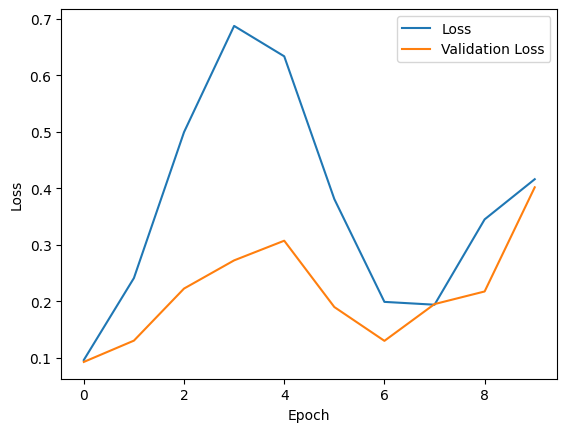

In [ ]:
model = Sequential()

model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=[Accuracy()])

model.summary()

history = model.fit(X_train.values, y_train.values,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val.values, y_val.values))

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


53/53 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<__array_function__ internals>", line 180, in mean
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py", line 3432, in mean
    return _methods._mean(a, axis=axis, dtype=dtype,
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py", line 168, in _mean
    rcount = _

53/53 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters found:  {'dropout_rate': 0.0, 'learning_rate': 0.001}
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 128)               914048    
                                                                 
 dense_112 (Dense)           (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 120)               7800      
                                                                 
Total params: 930104 (3.55 MB)
Trainable params: 930104 (3.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
159/159 [==============================] - 1s 6ms/step - loss: 1.074

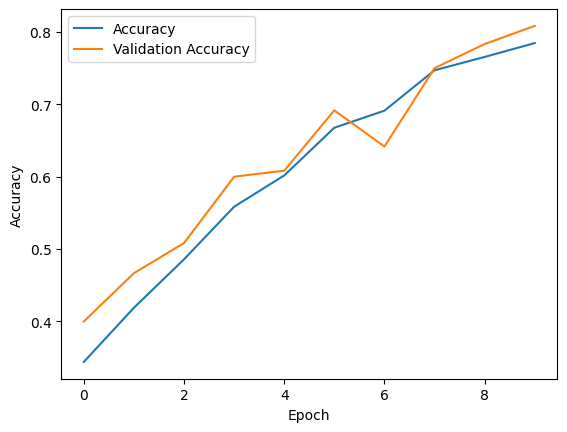

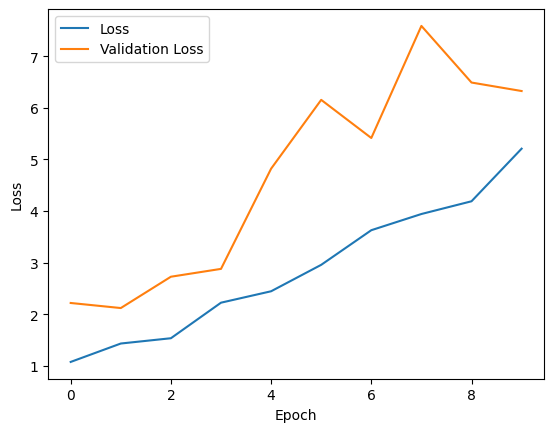

In [ ]:
class KerasWrapper(BaseEstimator):
    def __init__(self, dropout_rate=0.0, learning_rate=0.001):
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate

    def fit(self, X, y, **fit_params):
        self.model = self.build_model()
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(y_train.shape[1], activation='softmax'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=CategoricalCrossentropy(), metrics=[Accuracy()])
        return model

kf = KFold(n_splits=3, shuffle=True, random_state=42)

keras_model = KerasWrapper()

param_grid = {
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
    'learning_rate': [0.001, 0.01, 0.1],
}

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring=make_scorer(np.mean), cv=kf)
grid_result = grid.fit(X_train.values, y_train.values, epochs=10, batch_size=32, verbose=0, validation_data=(X_val.values, y_val.values))

print("Best parameters found: ", grid_result.best_params_)

best_model = grid_result.best_estimator_.model
best_model.summary()

history_optimized = best_model.fit(X_train.values, y_train.values,
                                   epochs=10,
                                   batch_size=32,
                                   validation_data=(X_val.values, y_val.values))

plt.plot(history_optimized.history['accuracy'], label='Accuracy')
plt.plot(history_optimized.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_optimized.history['loss'], label='Loss')
plt.plot(history_optimized.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
